ProgEcon: Project 1

Group: Nikolaj and Fanny

In [95]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# APIs
from fredapi import Fred
from dstapi import DstApi

# Plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# 1. Aggregate inflation in Denmark

## 1.1 Basic


We are using table PRIS113 from Denmark Statistics to examine the post-pandemic inflation surge end in Denmark.

**Figure 1: Consumer Price Index (2020=100)** : shows a clear level shift upward after 2020.  
**Figure 2: Monthly inflation rate (m/m)** : spikes strongly around 2021–2022.  
**Figure 3: 12-month inflation rate (y/y)** : rises sharply to about 10% in 2022, then drops steeply and stabilizes around 2% from mid-2023 onward.  

The post-pandemic inflation surge in Denmark ended around mid-2023, when the 12-month inflation rate fell back to a low and stable level consistent with pre-pandemic norms.


In [96]:
# 1) Data form DST PRIS 113
PRIS113 = DstApi('PRIS113')  
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2025-11-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,550,1980M01,1980M01,2025M10,2025M10,True


In [97]:
# 2) Generatring data frame 

# a) Parameters  
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},  # CPI
        {'code': 'TID',  'values': ['*']}        # Time 
    ]
}
# b) Downloading data with parameter  
cpi = PRIS113.get_data(params=params)

# # c) Displaying data  
# display(cpi.head(5))
# display(cpi.info())

# d) Renaming variables  
cpi = cpi.rename(columns={'INDHOLD': 'P'})
cpi['Time'] = pd.to_datetime(cpi['TID'], format='%YM%m')
cpi = cpi.sort_values('Time').reset_index(drop=True)

# e) Changing type  
cpi['P'] = cpi['P'].astype(float)

# f) Index  
m2020 = cpi['Time'].dt.year == 2020
base = cpi.loc[m2020, 'P'].mean()
cpi['P_2020=100'] = cpi['P'] / base * 100

# g) Inflation 
cpi['pi'] = cpi['P'].pct_change(1) # month to month inflation 
cpi['pi12'] = cpi['P'].pct_change(12) # 12-month inflation

# h) Droping columns  
cpi = cpi.drop(columns=['TYPE', 'TID'])  


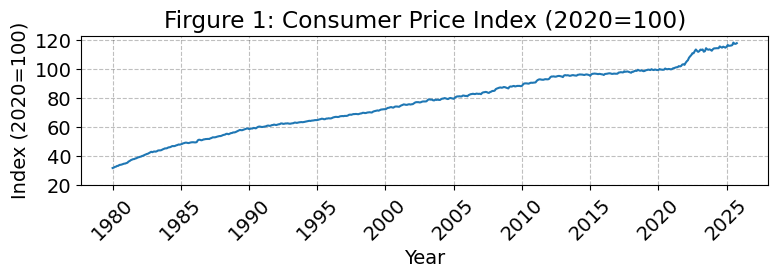

In [98]:
#Figures

# a) Index
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['P_2020=100'], color=colors[0])
ax.set_title('Firgure 1: Consumer Price Index (2020=100)')
ax.set_xlabel('Year')
ax.set_ylabel('Index (2020=100)')
ax.set_yticks([20, 40, 60, 80, 100, 120])
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

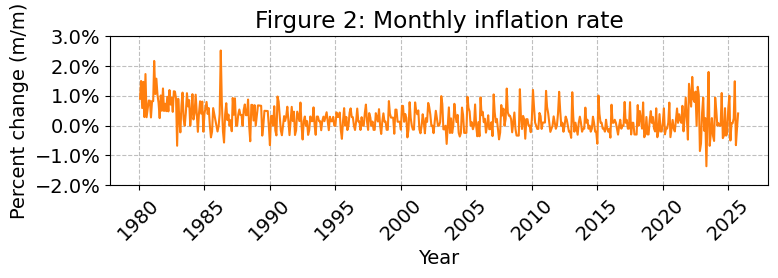

In [99]:
# b) month to month inflation
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['pi'], color=colors[1])
ax.set_title('Firgure 2: Monthly inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (m/m)')
ax.set_yticks([-0.02, -0.01, 0, 0.01, 0.02, 0.03]) 
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


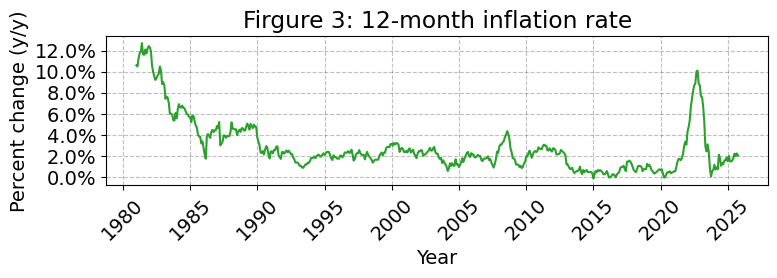

In [100]:
# c) 12-month inflation
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(cpi['Time'], cpi['pi12'], color=colors[2])
ax.set_title('Firgure 3: 12-month inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (y/y)')
ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]) 
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

## 1.2 Instantaneous
The instantaneous inflation rate is defined as:
$$
\begin{align*}
\pi_t^{12,\alpha} &= \left( \prod_{k=0}^{11} (1 + \pi_{t-k})^{\kappa(k,\alpha)} \right) - 1, \\[6pt]
\kappa(k,\alpha) &= \frac{(T - k)^{\alpha}}{\sum (T - k)^{\alpha} \, }T
\end{align*}
$$

Figure 4 shows that larger α makes the measure more responsive by emphasizing recent inflation changes, while α = 0 gives equal weights across all 12 months.

Figure 5 shows that the instantaneous 12-month inflation peaked around mid-2022 and returned near zero by early 2023. This suggests that the post-pandemic inflation surge ended slightly earlier than indicated by the year-over-year measure.



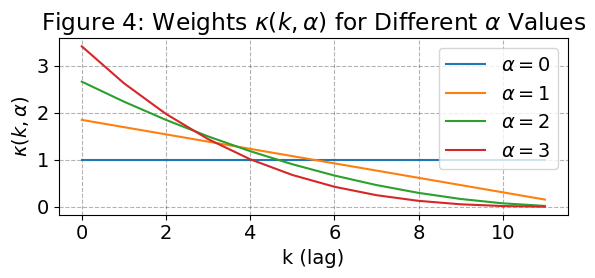

In [101]:
# 1) Creating function 
# Define kappa
def kappa(alpha, T=12):
    k = np.arange(T)
    return k, (T - k)**alpha / np.sum((T - np.arange(T))**alpha) * T

# The weights for alpha
alphas = [0, 1, 2, 3]

# 2) Plot kappa with weights 
# a) Creating figure
fig, ax = plt.subplots(figsize=(6, 3))
for a in alphas:
    k, w = kappa(a)
    ax.plot(k, w, label=fr'$\alpha={a}$')

# 3) Labels and style
ax.set_title(r'Figure 4: Weights $\kappa(k, \alpha)$ for Different $\alpha$ Values')
ax.set_xlabel('k (lag)')
ax.set_ylabel(r'$\kappa(k, \alpha)$')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [102]:
# 3) Computing inflation year 
def inflation_year(pi, alpha, T=12):
    _, w_k = kappa(alpha, T)
    w = w_k[::-1]  

    # a) Rolling 
    res = pi.rolling(12).apply(
        lambda x: np.prod((1 + x)**w) - 1,
        raw=True
    )
    return res

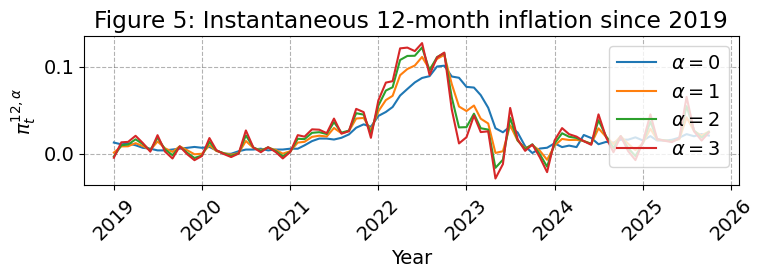

In [103]:
# 4) Plots instantaneous inflation since 2019
# a) Creating figure
fig, ax = plt.subplots(figsize=(8, 3))
for a in alphas:
    pi_year = inflation_year(cpi['pi'], a) 
    mask_2019 = cpi['Time'] >= '2019-01-01'
    time_2019 = cpi.loc[mask_2019, 'Time']
    pi_2019 = pi_year[mask_2019]
    
    ax.plot(time_2019, pi_2019, label=fr'$\alpha={a}$')

# b) Labels and style
ax.set_title("Figure 5: Instantaneous 12-month inflation since 2019")
ax.set_ylabel(r'$\pi_t^{12,\alpha}$')
ax.set_xlabel("Year")
ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.3 Core inflation

Using the PRIS111 table from Statistics Denmark, we construct a figure showing 12-month inflation rates since 2019. Figure 6 reveals that the total CPI increased far more sharply than the series excluding energy, indicating that energy prices were the primary driver of the post-pandemic inflation surge. As energy prices normalised, the inflation measures converged, demonstrating that underlying core inflation pressures were considerably more moderate

In [104]:
# 1) data DST PRIS111
PRIS111 = DstApi('PRIS111')  
PRIS111.tablesummary(language='en')

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-11-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,298,2001M01,2001M01,2025M10,2025M10,True


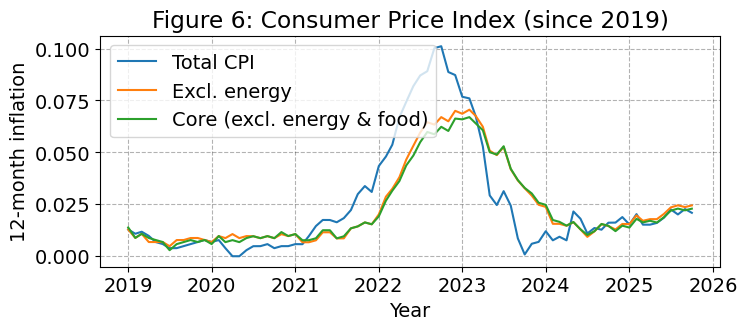

In [105]:
# 2) Generatering data frame 
# a) data form DST PRIS111 
params_v2 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},  # total, excl. energy, core
        {'code': 'ENHED',  'values': ['100']},                         # "Index"
        {'code': 'Tid',    'values': ['*']}                            # all months
    ]
}

cpi_v2 = PRIS111.get_data(params=params_v2)


# b) Renaming and sorting
cpi_v2 = cpi_v2.rename(columns={'INDHOLD':'P', 'TID':'Time'})
cpi_v2['Time'] = pd.to_datetime(cpi_v2['Time'], format='%YM%m')
cpi_v2['P'] = pd.to_numeric(cpi_v2['P'], errors='coerce')
cpi_v2 = cpi_v2.sort_values(['VAREGR','Time']).reset_index(drop=True)
cpi_v2['pi12'] = cpi_v2.groupby('VAREGR')['P'].pct_change(12) # 12 mouth inflation 


# 3) Plot since 2019
series_dict = {
    'Total CPI'                     : cpi_v2['VAREGR'].str.startswith('00 '),
    'Excl. energy'                  : cpi_v2['VAREGR'].str.startswith('15.1 '),
    'Core (excl. energy & food)'    : cpi_v2['VAREGR'].str.startswith('14.1 ')
}

fig, ax = plt.subplots(figsize=(8,3))
for name, mask in series_dict.items():
    df = cpi_v2.loc[mask]
    df = df[df['Time'] >= '2019-01-01']
    ax.plot(df['Time'], df['pi12'], label=name)


ax.set_title("Figure 6: Consumer Price Index (since 2019)")
ax.set_xlabel("Year")
ax.set_ylabel("12-month inflation")
ax.legend()
ax.grid(alpha=0.3)
plt.show()


## 1.4 Disaggregated inflation in Denmark

C:\Users\fanny\AppData\Local\Temp\ipykernel_29088\192884837.py:34: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  100 * cpi_4digit.groupby('VAREGR')['P'].pct_change(12)


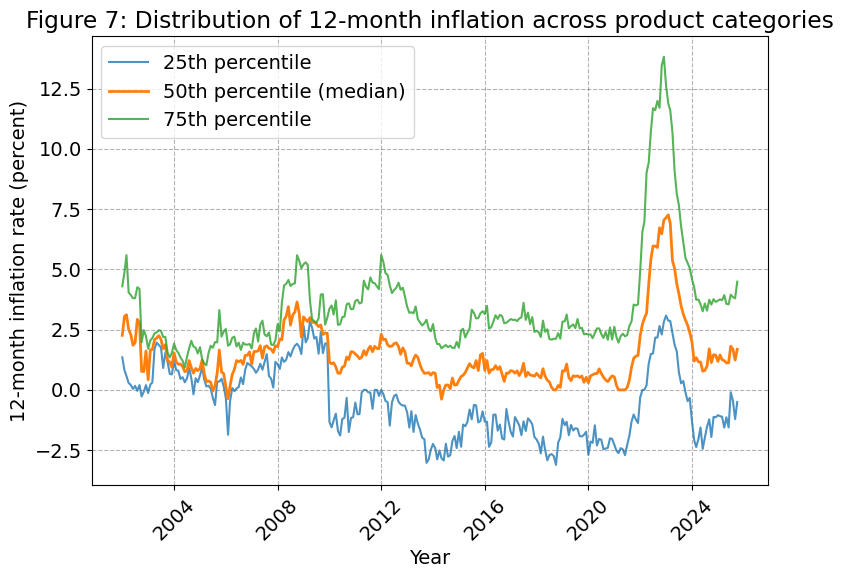

In [113]:
# # 1) list of all 4-digit product categories
levels = PRIS111.variable_levels('VAREGR', language='en')

four_digit_codes = []
for row in levels.itertuples():
    # Only categories where the 5th character is not '0' 
    if len(row.id) == 6 and row.id[4] != '0':
        four_digit_codes.append(row.id)

# 2) Generating data frame 
# a Creatring params for all 4-digit categories
params_4digit = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': four_digit_codes},
        {'code': 'ENHED',  'values': ['100']},     # Index (2020=100)
        {'code': 'Tid',    'values': ['*']}        # all months
    ]
}

cpi_4digit = PRIS111.get_data(params=params_4digit)

# b) Renaming and sorting
cpi_4digit = cpi_4digit.rename(columns={'INDHOLD':'P', 'TID':'Time'})
cpi_4digit['Time'] = pd.to_datetime(cpi_4digit['Time'], format='%YM%m')
cpi_4digit['P'] = pd.to_numeric(cpi_4digit['P'], errors='coerce')

cpi_4digit = cpi_4digit.sort_values(['VAREGR','Time']).reset_index(drop=True)

# c) 12-month inflation for each 4-digit category
cpi_4digit['pi12'] = (
    100 * cpi_4digit.groupby('VAREGR')['P'].pct_change(12)
)

# d) Calculating percentiles for each month
monthly_percentiles = cpi_4digit.groupby('Time')['pi12'].agg([
    lambda x: x.quantile(0.25),   # 25th percentile
    lambda x: x.quantile(0.50),   # median
    lambda x: x.quantile(0.75)    # 75th percentile
]).reset_index()

monthly_percentiles.columns = ['Time', 'p25', 'p50', 'p75']

# 3) figure


fig, ax = plt.subplots(figsize=(8,6))

ax.plot(monthly_percentiles['Time'], monthly_percentiles['p25'],
        label='25th percentile', alpha=0.8)

ax.plot(monthly_percentiles['Time'], monthly_percentiles['p50'],
        label='50th percentile (median)', linewidth=2)

ax.plot(monthly_percentiles['Time'], monthly_percentiles['p75'],
        label='75th percentile', alpha=0.8)

ax.set_title('Figure 7: Distribution of 12-month inflation across product categories')
ax.set_xlabel('Year')
ax.set_ylabel('12-month inflation rate (percent)')

ax.legend()
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


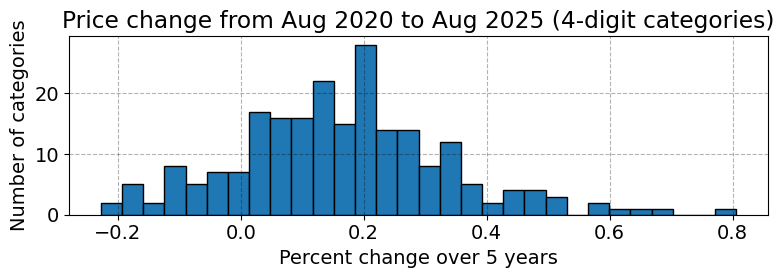

In [114]:
# 4) Change in percent 

# a) Filter data for Aug 2020 and Aug 2025, then pivot
dates_to_filter = pd.to_datetime(['2020-08-01', '2025-08-01'])
subset = cpi_4digit[cpi_4digit['Time'].isin(dates_to_filter)]
price_change = subset.pivot(index='VAREGR', columns='Time', values='P')

# b) Calculating percent change
price_change['pct_change'] = (price_change['2025-08-01'] / price_change['2020-08-01'] - 1)

# c) Droping missing categories
price_change = price_change.dropna(subset=['pct_change'])

# 5) Histogram
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(price_change['pct_change'], bins=30, edgecolor='k')
ax.set_title('Price change from Aug 2020 to Aug 2025 (4-digit categories)')
ax.set_xlabel('Percent change over 5 years')
ax.set_ylabel('Number of categories')
ax.grid(alpha=0.3)
plt.tight_layout() 
plt.show()

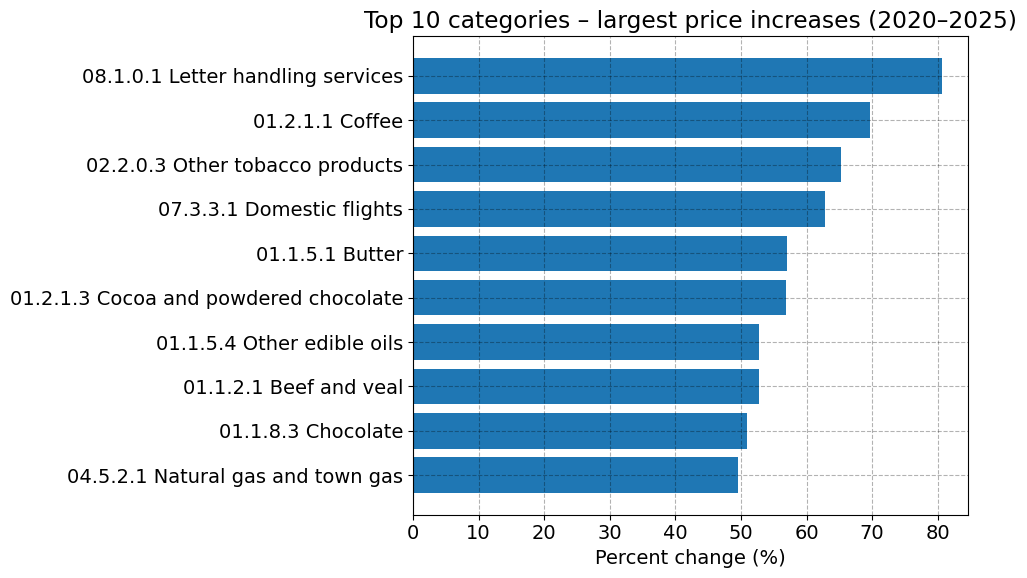

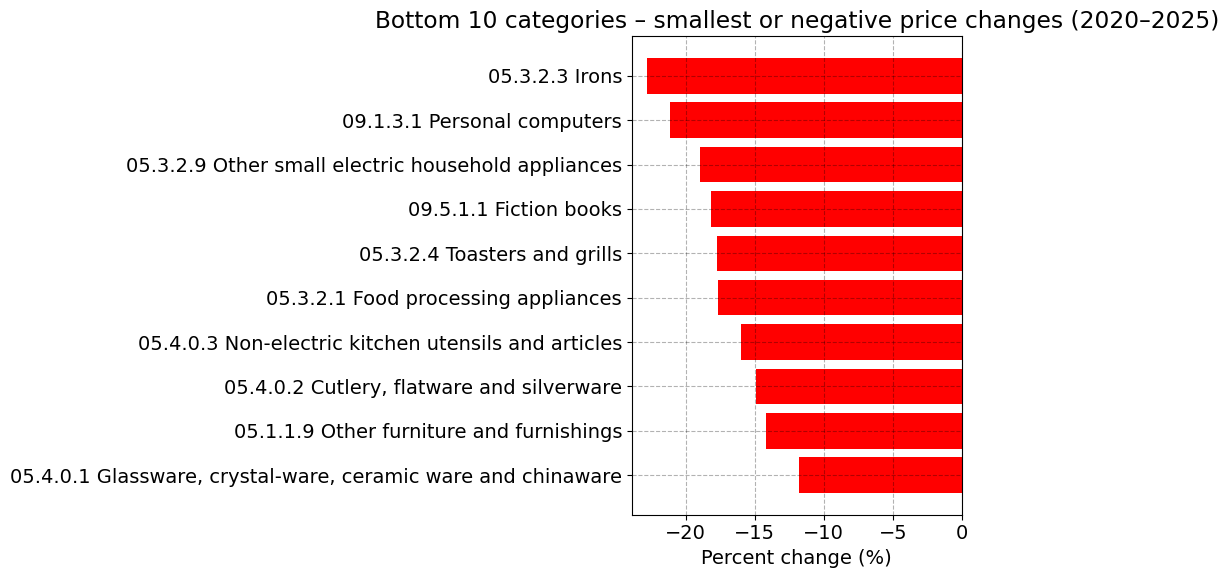

In [115]:
# 6) Top 10 and bund 10
top10 = price_change.nlargest(10, 'pct_change')
bottom10 = price_change.nsmallest(10, 'pct_change')


# 7) Bar Plots
# a) Top 10 
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(top10.index[::-1], (top10['pct_change']*100).iloc[::-1])
ax.set_title('Top 10 categories – largest price increases (2020–2025)')
ax.set_xlabel('Percent change (%)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# b) Bottom 10 
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(bottom10.index[::-1], (bottom10['pct_change']*100).iloc[::-1], color='red')
ax.set_title('Bottom 10 categories – smallest or negative price changes (2020–2025)')
ax.set_xlabel('Percent change (%)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. International Comparison

## 2.1 CPI vs HICP

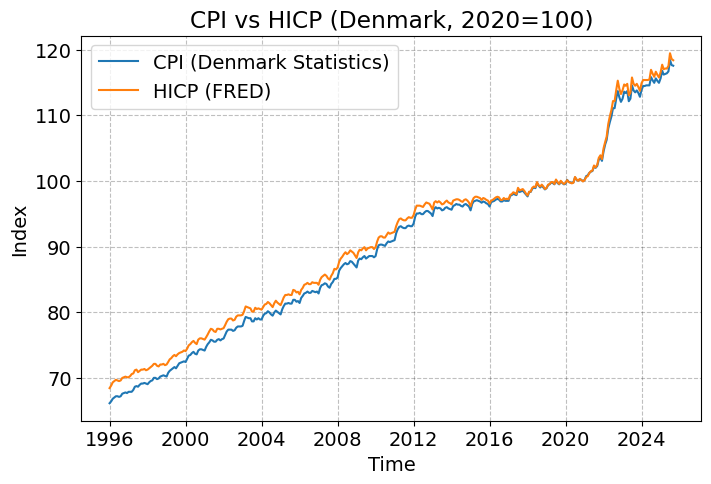

Correlation between CPI and HICP: 0.9994533812737144


In [116]:
# --- Assignment 2.1: CPI vs HICP ---------------------------------------------

from fredapi import Fred

# 1) connecting to FRED)
fred = Fred(api_key='c3a776f71a15da1b61d81dfde7d34030')

# 2) downloading HICP for Denmark
hicp = fred.get_series('CP0000DKM086NEST')
hicp = hicp.reset_index()
hicp.columns = ['Time', 'HICP']

# 3) align with your CPI data
df = pd.merge(cpi[['Time', 'P_2020=100']], hicp, on='Time', how='inner')

# 4) rebasing HICP to 2020 = 100
mask_2020 = df['Time'].dt.year == 2020
base_hicp = df.loc[mask_2020, 'HICP'].mean()
df['HICP_2020=100'] = df['HICP'] / base_hicp * 100

# 5) plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df['Time'], df['P_2020=100'], label='CPI (Denmark Statistics)')
plt.plot(df['Time'], df['HICP_2020=100'], label='HICP (FRED)')
plt.title('CPI vs HICP (Denmark, 2020=100)')
plt.ylabel('Index')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

# 6) optional: correlation check
print("Correlation between CPI and HICP:", df['P_2020=100'].corr(df['HICP_2020=100']))

## 2.2 Across countries

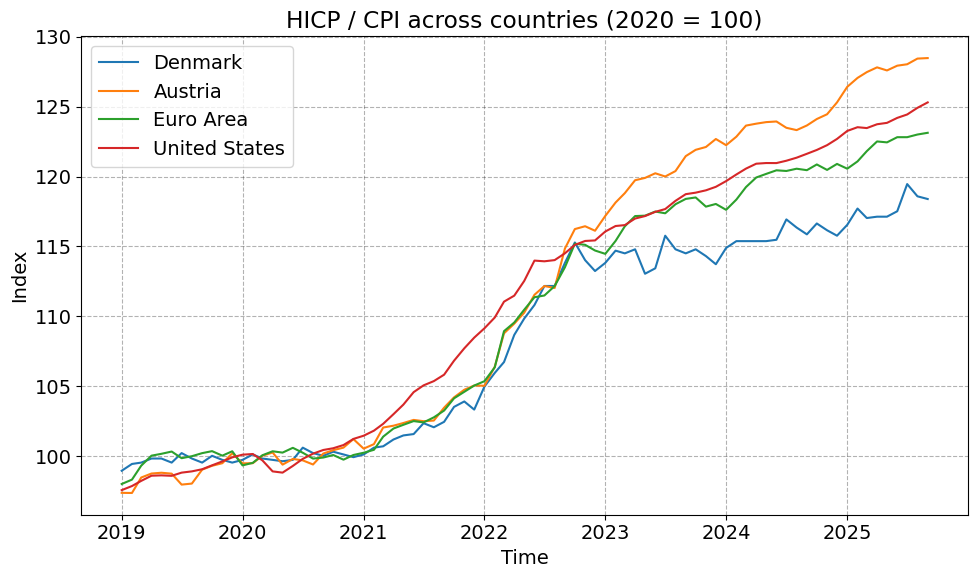

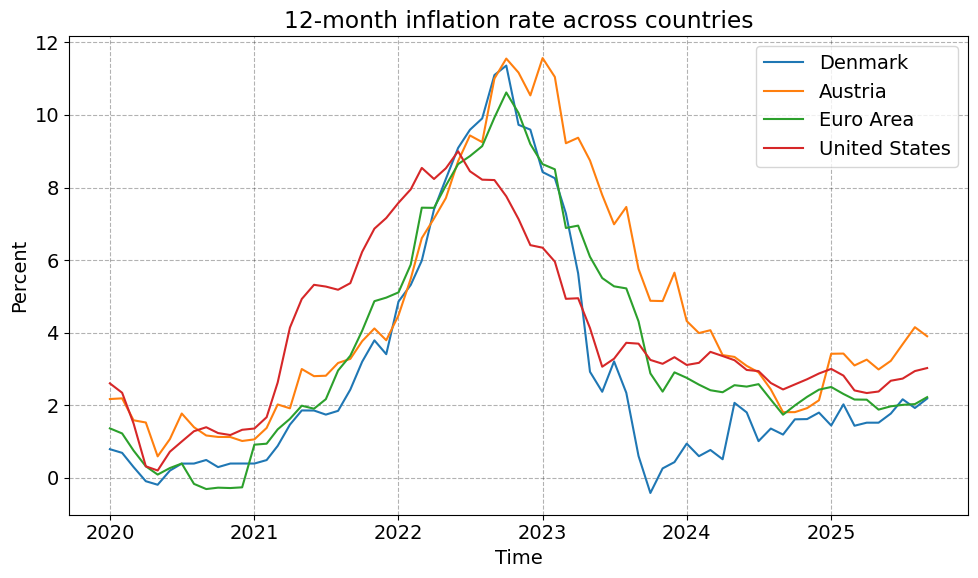

Denmark              Austria              Euro Area               \
         min    max  mean     min    max  mean       min    max  mean   
Year                                                                    
2019     NaN    NaN   NaN     NaN    NaN   NaN       NaN    NaN   NaN   
2020   -0.19   0.79  0.33    0.59   2.19  1.39     -0.31   1.36  0.26   
2021    0.39   3.79  1.94    1.06   4.11  2.76      0.91   4.96  2.59   
2022    4.85  11.36  8.51    4.48  11.55  8.59      5.11  10.62  8.36   
2023   -0.42   8.43  3.44    4.87  11.57  7.78      2.37   8.64  5.46   
2024    0.51   2.06  1.27    1.81   4.32  2.93      1.74   2.75  2.36   
2025    1.43   2.18  1.77    2.98   4.15  3.46      1.88   2.50  2.14   

     United States              
               min   max  mean  
Year                            
2019           NaN   NaN   NaN  
2020          0.20  2.60  1.25  
2021          1.36  7.16  4.67  
2022          6.41  9.00  8.00  
2023          3.06  6.34  4.15  
2024          2.43  3.47  2.95  
2025          2.33  3.02  2.70

In [117]:

# from fredapi import Fred
# import pandas as pd
# import matplotlib.pyplot as plt

fred = Fred(api_key='c3a776f71a15da1b61d81dfde7d34030')

# brug kun serier, som findes på FRED
codes = {
    'Denmark': 'CP0000DKM086NEST',
    'Austria': 'CP0000ATM086NEST',
    'Euro Area': 'CP0000EZ19M086NEST',
    'United States': 'CPIAUCSL'
}

data = pd.DataFrame()
for country, code in codes.items():
    series = fred.get_series(code)
    df = pd.DataFrame(series).rename(columns={0: country})
    data = pd.concat([data, df], axis=1)

data.index.name = 'Time'
data = data[data.index >= '2019-01-01']

# rebase til 2020 = 100
base_mask = (data.index.year == 2020)
base_values = data.loc[base_mask].mean()
data_indexed = data / base_values * 100

# plot indeks
plt.figure(figsize=(10,6))
for col in data_indexed.columns:
    plt.plot(data_indexed.index, data_indexed[col], label=col)
plt.title('HICP / CPI across countries (2020 = 100)')
plt.ylabel('Index')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# beregn 12-måneders inflation
infl = data.pct_change(12) * 100

# plot inflation
plt.figure(figsize=(10,6))
for col in infl.columns:
    plt.plot(infl.index, infl[col], label=col)
plt.title('12-month inflation rate across countries')
plt.ylabel('Percent')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# opsummer min, max, mean per år
infl['Year'] = infl.index.year
summary = infl.groupby('Year')[list(codes.keys())].agg(['min','max','mean'])
display(summary.round(2))

# 3. Extension

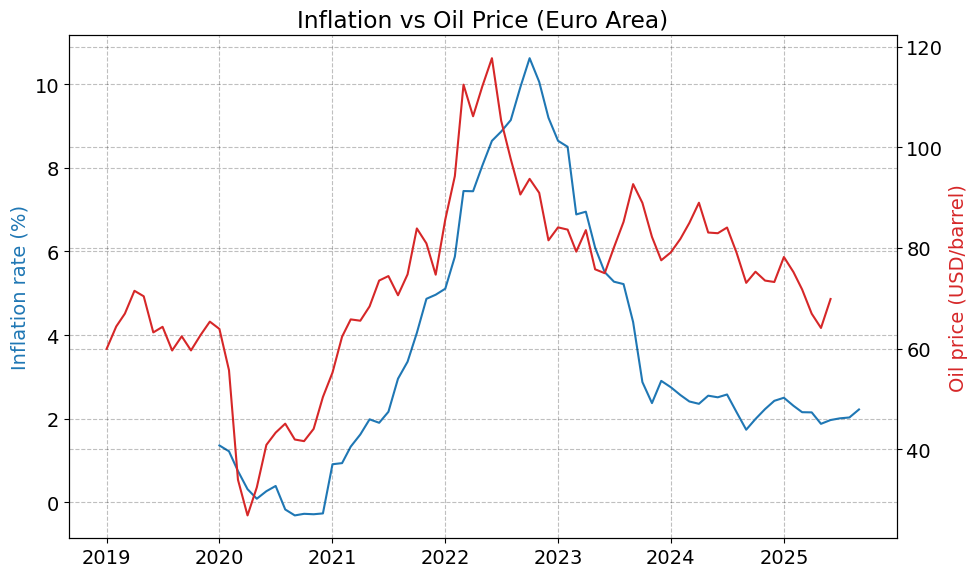

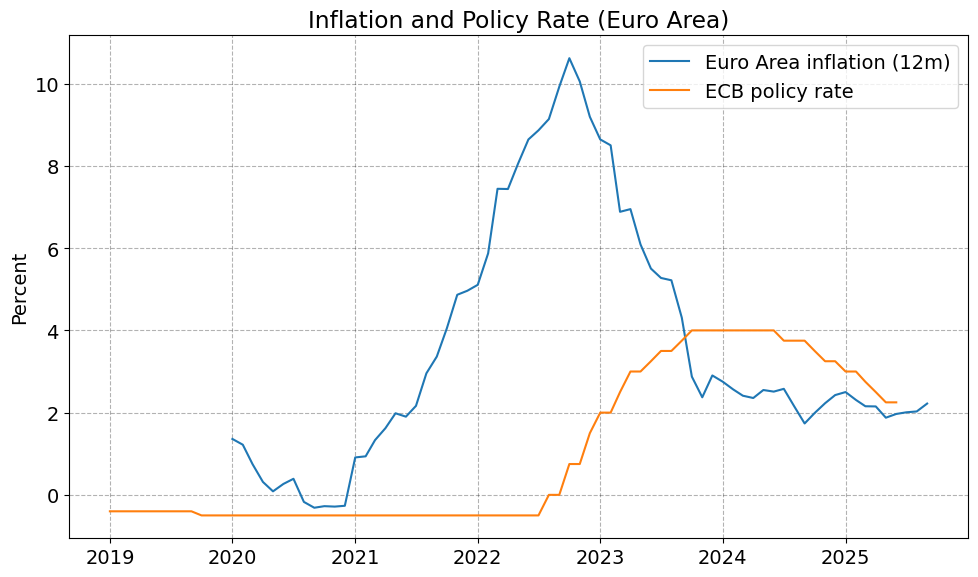

,Denmark,Austria,Euro Area,United States
,mean,mean,mean,mean
Time,,,,
2019,NaN,NaN,NaN,NaN
2020,0.33,1.39,0.26,1.25
2021,1.94,2.76,2.59,4.67
2022,8.51,8.59,8.36,8.00
2023,3.44,7.78,5.46,4.15
2024,1.27,2.93,2.36,2.95
2025,1.77,3.46,2.14,2.70


Insight:
The surge in inflation after 2021 coincides with sharp rises in energy prices.
Policy rates began increasing with a delay of about one year, showing the typical monetary policy response lag.


In [118]:
# from fredapi import Fred
# import pandas as pd
# import matplotlib.pyplot as plt

fred = Fred(api_key='c3a776f71a15da1b61d81dfde7d34030')

# --- Base inflation data (from your earlier analysis) ---
codes = {
    'Denmark': 'CP0000DKM086NEST',
    'Austria': 'CP0000ATM086NEST',
    'Euro Area': 'CP0000EZ19M086NEST',
    'United States': 'CPIAUCSL'
}

inflation = pd.DataFrame()
for country, code in codes.items():
    series = fred.get_series(code)
    df = pd.DataFrame(series).rename(columns={0: country})
    inflation = pd.concat([inflation, df], axis=1)

inflation.index.name = 'Time'
inflation = inflation[inflation.index >= '2019-01-01']
infl_12m = inflation.pct_change(12) * 100

# --- Extension: Add energy prices and interest rates ---
extra_codes = {
    'Brent Oil (USD/barrel)': 'POILBREUSDM',     # World Bank oil price
    'US Policy Rate': 'FEDFUNDS',                # Federal Funds Rate
    'ECB Policy Rate': 'ECBDFR',                 # Euro area deposit facility rate
    'Denmark Policy Rate': 'IRLTLT01DKM156N'     # DK long-term rate (proxy)
}

extra_data = pd.DataFrame()
for name, code in extra_codes.items():
    s = fred.get_series(code)
    extra_data[name] = s

# align data
extra_data = extra_data[extra_data.index >= '2019-01-01']

# --- Plot 1: Inflation vs Energy prices ---
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(infl_12m.index, infl_12m['Euro Area'], label='Euro Area inflation (12m)', color='tab:blue')
ax1.set_ylabel('Inflation rate (%)', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(extra_data.index, extra_data['Brent Oil (USD/barrel)'], label='Brent oil price', color='tab:red')
ax2.set_ylabel('Oil price (USD/barrel)', color='tab:red')
plt.title('Inflation vs Oil Price (Euro Area)')
fig.tight_layout()
plt.show()

# --- Plot 2: Policy rates vs Inflation ---
plt.figure(figsize=(10,6))
plt.plot(infl_12m.index, infl_12m['Euro Area'], label='Euro Area inflation (12m)')
plt.plot(extra_data.index, extra_data['ECB Policy Rate'], label='ECB policy rate')
plt.title('Inflation and Policy Rate (Euro Area)')
plt.ylabel('Percent')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 3: Compare inflation and rates across countries ---
summary = infl_12m.groupby(infl_12m.index.year).agg(['mean'])
display(summary.round(2))

print("Insight:")
print("The surge in inflation after 2021 coincides with sharp rises in energy prices.")
print("Policy rates began increasing with a delay of about one year, showing the typical monetary policy response lag.")
